In [2]:
import pandas as pd

#storing the dataset into the variable dataset, also making the "DATE" column the index column
dataset = pd.read_csv("/Users/bhimrajj/Downloads/alpha.csv", index_col="DATE")


In [13]:
#For each column, store the percentage of missing values
miss_pct = dataset.apply(pd.isnull).sum()/dataset.shape[0]

In [14]:
#print the missing values percentages for each column
miss_pct

STATION    0.000000
NAME       0.000000
ACMH       0.524697
ACSH       0.524549
AWND       0.253967
FMTM       0.496925
PGTM       0.281145
PRCP       0.000099
PSUN       0.746528
SNOW       0.000000
SNWD       0.419411
TAVG       0.651012
TMAX       0.000000
TMIN       0.000000
TSUN       0.508034
WDF1       0.822059
WDF2       0.475997
WDF5       0.477187
WDFG       0.528913
WDFM       0.703829
WESD       0.678040
WSF1       0.822059
WSF2       0.475997
WSF5       0.477187
WSFG       0.528367
WSFM       0.703829
WT01       0.618826
WT02       0.942521
WT03       0.953481
WT04       0.980311
WT05       0.980262
WT06       0.987899
WT07       0.996925
WT08       0.868082
WT09       0.991024
WT10       0.999950
WT11       0.999058
WT13       0.884497
WT14       0.938603
WT15       0.996578
WT16       0.667526
WT17       0.996429
WT18       0.905921
WT19       0.998115
WT21       0.999901
WT22       0.995437
dtype: float64

In [15]:
#list columns with low miss_pct (good columns) "feel free to tweak the threshold of how low we want missing values to be"
good_columns = dataset.columns[miss_pct < 0.01]

In [16]:
good_columns

Index(['STATION', 'NAME', 'PRCP', 'SNOW', 'TMAX', 'TMIN'], dtype='object')

In [17]:
dataset = dataset[good_columns].copy()

In [18]:
dataset

,STATION,NAME,PRCP,SNOW,TMAX,TMIN
DATE,,,,,,
1970-01-01,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,29,16
1970-01-02,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,28,19
1970-01-03,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.14,2.2,30,17
1970-01-04,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.02,0.2,27,19
1970-01-05,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,30,18
...,...,...,...,...,...,...
2025-03-12,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,50,33
2025-03-13,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,44,34
2025-03-14,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,46,35


In [19]:
dataset.apply(pd.isnull).sum()/dataset.shape[0]

STATION    0.000000
NAME       0.000000
PRCP       0.000099
SNOW       0.000000
TMAX       0.000000
TMIN       0.000000
dtype: float64

In [20]:
#Since the "PRCP" column has missin values, we fill the missing values with zero since
#if there was no PRCP recorded for that day then that must mean that it did not rain therefore PRCP would be zero

dataset["PRCP"] = dataset["PRCP"].fillna(0)

In [21]:
dataset.apply(pd.isnull).sum()/dataset.shape[0]

STATION    0.0
NAME       0.0
PRCP       0.0
SNOW       0.0
TMAX       0.0
TMIN       0.0
dtype: float64

In [22]:
dataset.dtypes

STATION     object
NAME        object
PRCP       float64
SNOW       float64
TMAX         int64
TMIN         int64
dtype: object

In [23]:
dataset.index

Index(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04', '1970-01-05',
       '1970-01-06', '1970-01-07', '1970-01-08', '1970-01-09', '1970-01-10',
       ...
       '2025-03-07', '2025-03-08', '2025-03-09', '2025-03-10', '2025-03-11',
       '2025-03-12', '2025-03-13', '2025-03-14', '2025-03-15', '2025-03-16'],
      dtype='object', name='DATE', length=20164)

In [24]:
#Change dtype from object to datetime
dataset.index = pd.to_datetime(dataset.index)

In [25]:
dataset.index

DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
               '1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08',
               '1970-01-09', '1970-01-10',
               ...
               '2025-03-07', '2025-03-08', '2025-03-09', '2025-03-10',
               '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-14',
               '2025-03-15', '2025-03-16'],
              dtype='datetime64[ns]', name='DATE', length=20164, freq=None)

In [26]:
#Example of why convertingg dates from object to dates is helpful:
dataset.index.year

Int64Index([1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970, 1970,
            ...
            2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025],
           dtype='int64', name='DATE', length=20164)

In [27]:
#Check for gaps in dataset (if certain years have more rows than others, ideally each year should have around 365 ish rows)
dataset.index.year.value_counts().sort_index()

1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1981    365
1982    365
1983    365
1984    366
1985    365
1986    365
1987    365
1988    366
1989    365
1990    365
1991    365
1992    366
1993    365
1994    365
1995    365
1996    366
1997    365
1998    365
1999    365
2000    366
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024    366
2025     75
Name: DATE, dtype: int64

<AxesSubplot:xlabel='DATE'>

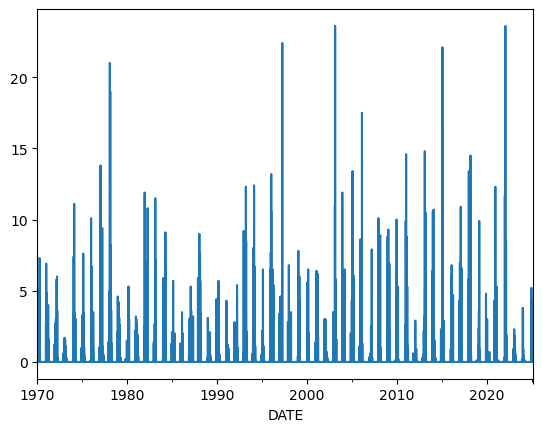

In [28]:
#Plot of snow depth in Boston.
dataset["SNOW"].plot()

In [29]:
dataset["tmrw_temp"] = dataset.shift(-1)["TMAX"]

In [30]:
dataset

,STATION,NAME,PRCP,SNOW,TMAX,TMIN,tmrw_temp
DATE,,,,,,,
1970-01-01,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,29,16,28.0
1970-01-02,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,28,19,30.0
1970-01-03,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.14,2.2,30,17,27.0
1970-01-04,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.02,0.2,27,19,30.0
1970-01-05,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,30,18,31.0
...,...,...,...,...,...,...,...
2025-03-12,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,50,33,44.0
2025-03-13,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,44,34,46.0
2025-03-14,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,46,35,62.0


In [31]:
#Filling last tmrw_temp with the one before since we don't know tmrw_temp actual temp for a day that has not yet come!
dataset = dataset.ffill()


In [32]:
dataset

,STATION,NAME,PRCP,SNOW,TMAX,TMIN,tmrw_temp
DATE,,,,,,,
1970-01-01,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,29,16,28.0
1970-01-02,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,28,19,30.0
1970-01-03,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.14,2.2,30,17,27.0
1970-01-04,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.02,0.2,27,19,30.0
1970-01-05,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,30,18,31.0
...,...,...,...,...,...,...,...
2025-03-12,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,50,33,44.0
2025-03-13,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,44,34,46.0
2025-03-14,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",0.00,0.0,46,35,62.0


Text(0.5, 1.0, 'Correlation Heatmap')

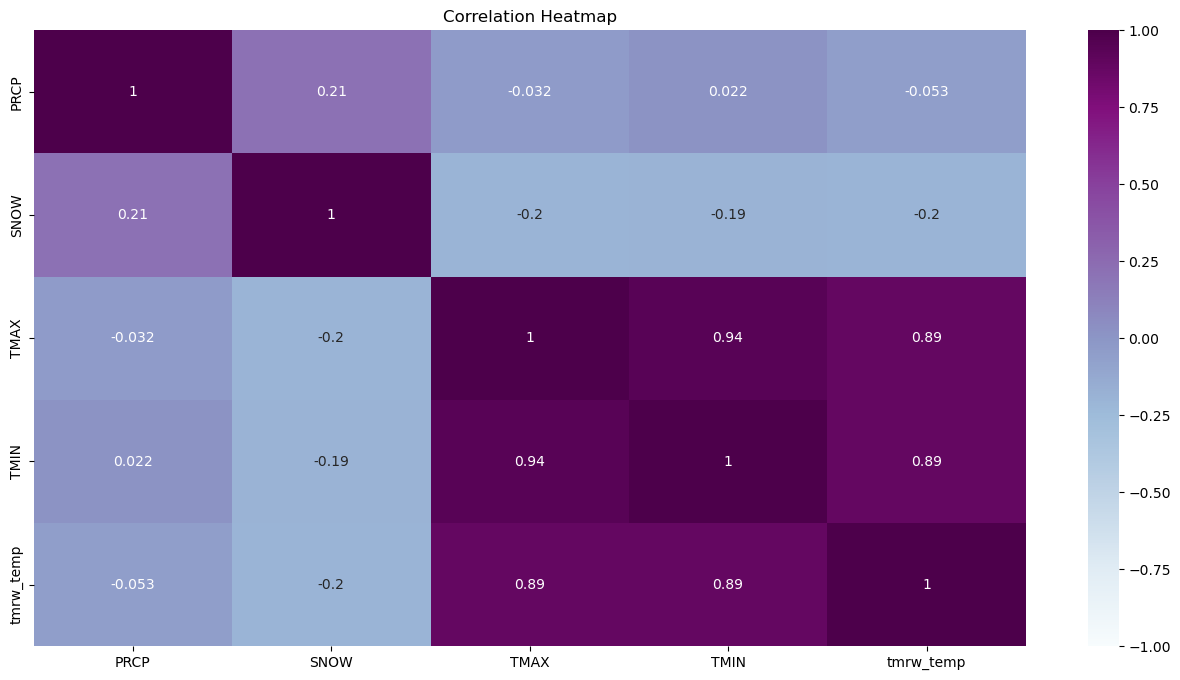

In [33]:
#Using pearson correlation coefficient between the numeric predictors
numeric_dataset = dataset.drop(columns=['STATION', 'NAME'], errors='ignore')
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(numeric_dataset.corr(), vmin=-1, vmax=1, annot=True, cmap='BuPu')
heatmap.set_title('Correlation Heatmap')

In [34]:
#As we can see, TMAX and TMIN are heavily correlated, TMAX and tmrw_temp are also heavily correlated. Other predictors are not highly correlated which makes sense

In [1]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
#XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

#Gradient Boosting
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

#Initializing predictors
predictors = ['TMAX', 'TMIN', 'PRCP', 'SNOW']
# XGBoost
predictions_xgb = backtest(dataset, xgb_model, predictors, start=3650)
# Gradient Boosting
predictions_gbr = backtest(dataset, gbr_model, predictors, start=3650)


NameError: name 'backtest' is not defined

In [45]:
#In this example the model starts predicting after it 10 years, (training on 10 years and predicting the next years till 2025 in 90 day intervals to account for seasons and such)
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        #training is from day 1 to i, i here is 3650 so training would be done on first 10 years in this case!
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        #fitting the model giving it the predictors and the target to train on
        model.fit(train[predictors], train["tmrw_temp"])

        #predicting the taregt for the test data but here we're obviously only given the predictors and our goal is to predict the target
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)


        #combining each 90 day interval into one big list:
        combined = pd.concat([test["tmrw_temp"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [46]:
predictions_10 = backtest(dataset, model, predictors)
predictions_xgb_10 = backtest(dataset, xgb_model, predictors)
predictions_gbr_10 = backtest(dataset, gbr_model, predictors)

In [51]:
display(predictions_10.head())
display(predictions_xgb_10.head())
display(predictions_gbr_10.head())

,actual,prediction,diff
DATE,,,
1979-12-30,41.0,44.371317,3.371317
1979-12-31,38.0,34.728448,3.271552
1980-01-01,37.0,42.066679,5.066679
1980-01-02,32.0,43.937143,11.937143
1980-01-03,27.0,32.681750,5.681750


,actual,prediction,diff
DATE,,,
1979-12-30,41.0,44.884239,3.884239
1979-12-31,38.0,41.019848,3.019848
1980-01-01,37.0,41.331215,4.331215
1980-01-02,32.0,39.385094,7.385094
1980-01-03,27.0,37.467850,10.467850


,actual,prediction,diff
DATE,,,
1979-12-30,41.0,45.326074,4.326074
1979-12-31,38.0,41.506374,3.506374
1980-01-01,37.0,40.551096,3.551096
1980-01-02,32.0,39.562806,7.562806
1980-01-03,27.0,36.849162,9.849162


In [3]:
import matplotlib.pyplot as plt

mae_results = {
    "Random Forest": predictions_10["diff"].mean(),
    "XGBoost": predictions_xgb["diff"].mean(),
    "Gradient Boosting": predictions_gbr["diff"].mean()
}

pd.Series(mae_results).plot(kind='bar', title="MAE Comparison of Models", ylabel="Mean Absolute Error")
plt.xticks(rotation=0)
plt.grid(True)
plt.show()



NameError: name 'predictions_10' is not defined

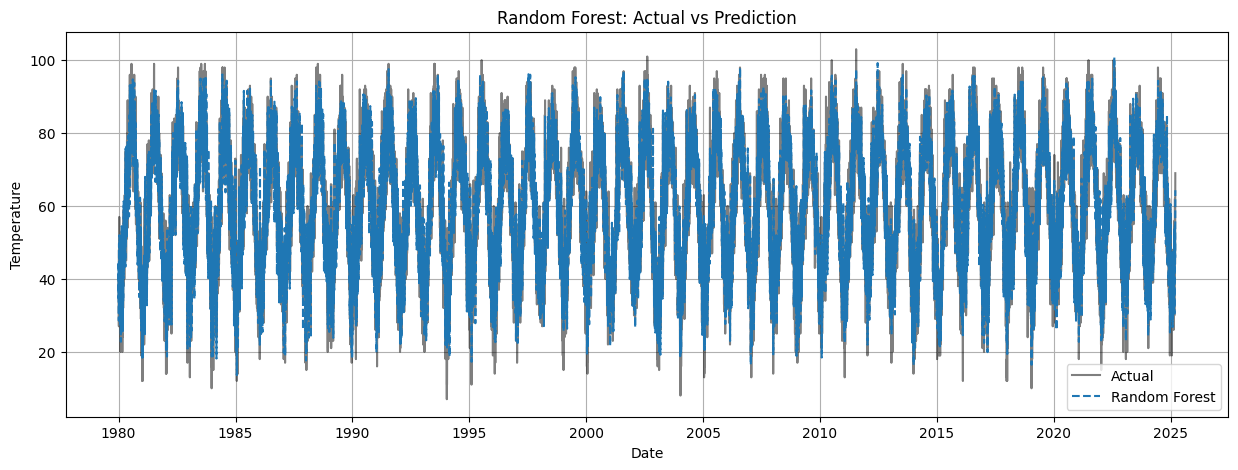

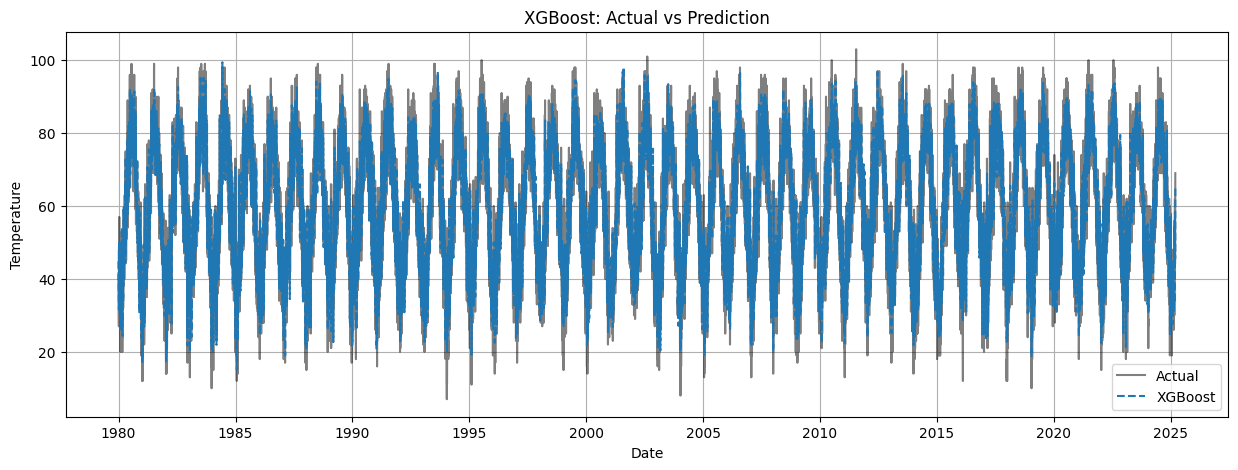

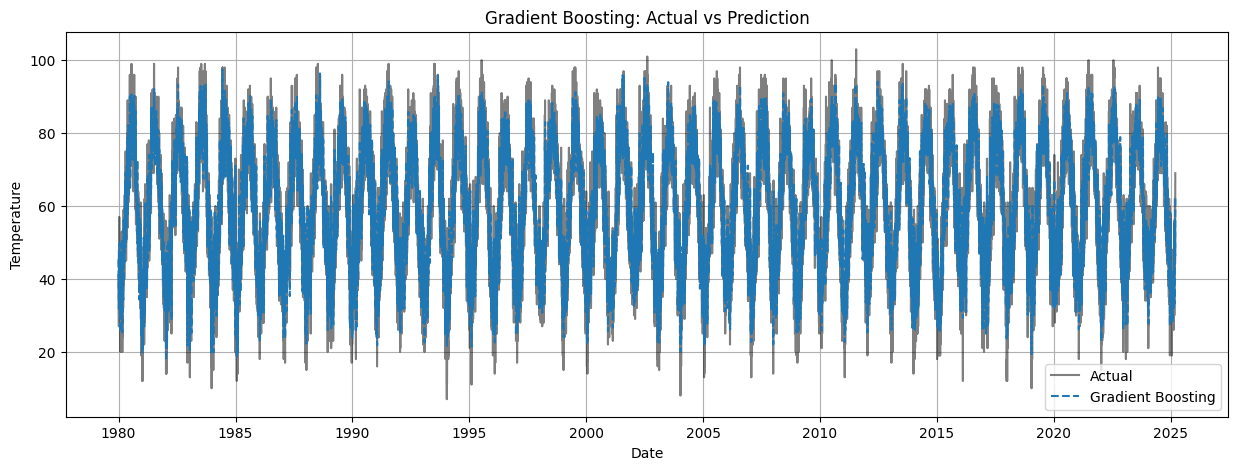

In [63]:
import matplotlib.pyplot as plt

# 设置图像大小
plt.figure(figsize=(15, 5))

# Plot for Random Forest
plt.plot(predictions_10.index, predictions_10["actual"], label="Actual", color="black", alpha=0.5)
plt.plot(predictions_10.index, predictions_10["prediction"], label="Random Forest", linestyle="--")

plt.title("Random Forest: Actual vs Prediction")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

# Plot for XGBoost
plt.figure(figsize=(15, 5))
plt.plot(predictions_xgb_10.index, predictions_xgb_10["actual"], label="Actual", color="black", alpha=0.5)
plt.plot(predictions_xgb_10.index, predictions_xgb_10["prediction"], label="XGBoost", linestyle="--")

plt.title("XGBoost: Actual vs Prediction")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

# Plot for Gradient Boosting
plt.figure(figsize=(15, 5))
plt.plot(predictions_gbr_10.index, predictions_gbr_10["actual"], label="Actual", color="black", alpha=0.5)
plt.plot(predictions_gbr_10.index, predictions_gbr_10["prediction"], label="Gradient Boosting", linestyle="--")

plt.title("Gradient Boosting: Actual vs Prediction")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

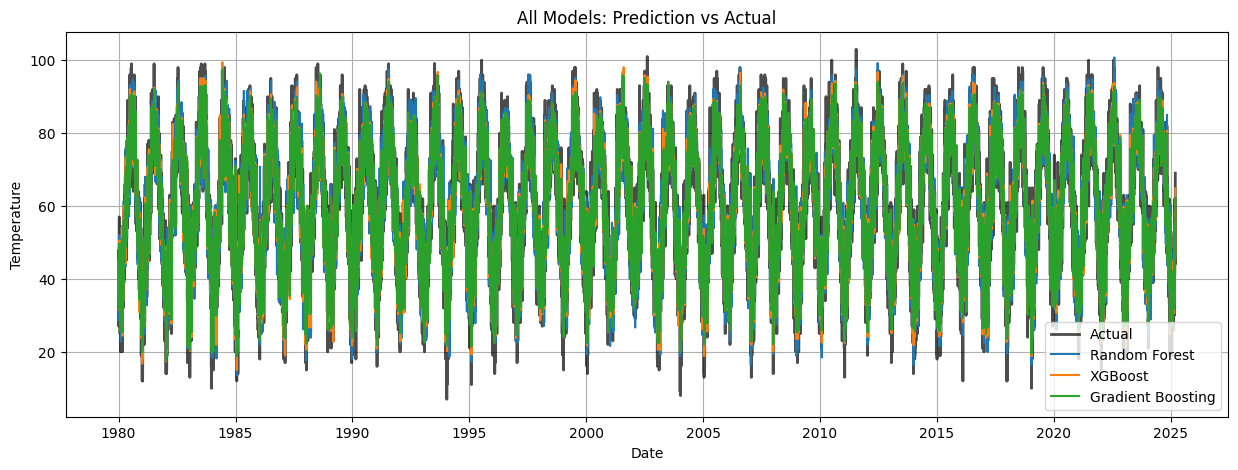

In [62]:
plt.figure(figsize=(15, 5))

plt.plot(predictions_10.index, predictions_10["actual"], label="Actual", color="black", linewidth=2, alpha=0.7)
plt.plot(predictions_10.index, predictions_10["prediction"], label="Random Forest")
plt.plot(predictions_xgb_10.index, predictions_xgb_10["prediction"], label="XGBoost")
plt.plot(predictions_gbr_10.index, predictions_gbr_10["prediction"], label="Gradient Boosting")

plt.title("All Models: Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [60]:
#Measurin how accurate our model is using mean absolute error:
predictions_10["diff"].mean()

np.float64(6.655374861779992)

In [59]:
predictions_xgb_10["diff"].mean()

np.float64(6.221273799171831)

In [61]:
predictions_gbr_10["diff"].mean()

np.float64(6.210035673668626)

In [33]:
#Attempting to improve accuracy (reduce average difference in temperature) by increasing the amount of data we train on from 10 years to 30 years:
prediction_30 = backtest(dataset, model, predictors, start=3650*3)

In [34]:
prediction_30

,actual,prediction,diff
DATE,,,
1999-12-25,41.0,27.943784,13.056216
1999-12-26,32.0,39.102532,7.102532
1999-12-27,26.0,37.300992,11.300992
1999-12-28,34.0,31.536960,2.463040
1999-12-29,49.0,38.169335,10.830665
...,...,...,...
2025-03-12,44.0,49.769964,5.769964
2025-03-13,46.0,47.645338,1.645338
2025-03-14,62.0,49.044058,12.955942


In [35]:
prediction_30["diff"].mean()

np.float64(6.285270333624122)

In [ ]:
#Wen's TMRW rain predication (another response variable)

In [ ]:
dataset["tmrw_rain"] = (dataset["PRCP"].shift(-1) > 0).astype(int)
dataset = dataset.dropna(subset=["tmrw_rain"])

In [ ]:
dataset

In [ ]:
dataset = dataset.ffill()

In [ ]:
dataset.corr(numeric_only=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Gradient Boosting Classifier
gbr_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [ ]:
def backtest(weather, model, predictors, target="tmrw_rain", start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        model.fit(train[predictors], train[target])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)

        combined = pd.concat([test[target], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["actual"] != combined["prediction"]).astype(int)

        all_predictions.append(combined)

    return pd.concat(all_predictions)

In [ ]:
predictions_rf_10 = backtest(dataset, model, predictors)
predictions_xgb_10 = backtest(dataset, xgb_model, predictors)
predictions_gbr_10 = backtest(dataset, gbr_model, predictors)

In [ ]:
predictions_10

In [ ]:
#Measurin how accurate our model is using mean absolute error:
from sklearn.metrics import accuracy_score

# Evaluate each model's prediction accuracy
print("Random Forest Accuracy:", accuracy_score(predictions_rf["actual"], predictions_rf["prediction"]))
print("XGBoost Accuracy:", accuracy_score(predictions_xgb["actual"], predictions_xgb["prediction"]))
print("Gradient Boosting Accuracy:", accuracy_score(predictions_gbr["actual"], predictions_gbr["prediction"]))


In [ ]:
# Threshold predictions to binary
for df in [predictions_rf, predictions_xgb, predictions_gbr]:
    df["pred_binary"] = (df["prediction"] > 0.5).astype(int)

# Pick a 1-year window
start_date = "2024-01-01"
end_date = "2025-01-01"

plot_rf = predictions_rf.loc[start_date:end_date]
plot_xgb = predictions_xgb.loc[start_date:end_date]
plot_gbr = predictions_gbr.loc[start_date:end_date]

plt.figure(figsize=(15, 6))
plt.step(plot_rf.index, plot_rf["actual"], label="Actual", linewidth=2)
plt.step(plot_rf.index, plot_rf["pred_binary"], label="Random Forest")
plt.step(plot_xgb.index, plot_xgb["pred_binary"], label="XGBoost")
plt.step(plot_gbr.index, plot_gbr["pred_binary"], label="Gradient Boosting")

plt.legend()
plt.title("Rain Prediction (Binary) vs Actual – Jan 2024 to Jan 2025")
plt.xlabel("Date")
plt.ylabel("Rain Tomorrow (0 or 1)")
plt.grid(True)
plt.tight_layout()
plt.show()